In [16]:
!pip install pymannkendall

In [17]:
import xee
import ee
import matplotlib.pyplot as plt
import geemap
import shapely.geometry
import geopandas as gpd
import xarray as xr
import pymannkendall as mk



In [3]:
ee.Authenticate()
ee.Initialize(project = 'ee-rahul20252027',opt_url = "https://earthengine-highvolume.googleapis.com")

In [7]:
Map = geemap.Map(basemap = 'SATELLITE')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [11]:
roi = Map.draw_features[-1]
roi = ee.Geometry(roi.getInfo()['geometry'])
roi_shape = shapely.geometry.shape(roi.getInfo())
gdf = gpd.GeoDataFrame({'geometry': [roi_shape]},crs = 'EPSG:4326')

In [12]:
collection = ee.ImageCollection("ECMWF/ERA5/MONTHLY").select('mean_2m_air_temperature').filterDate('1980','2025')

In [15]:
ds = xr.open_dataset(collection, engine = 'ee', crs = 'EPSG:4326', scale = 0.27, geometry = roi)

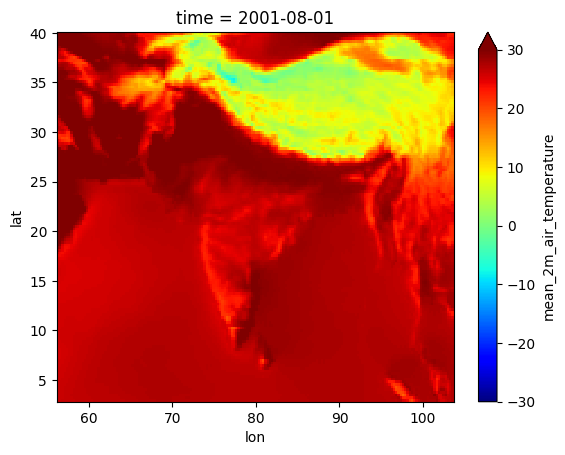

In [22]:
july_temp = ds['mean_2m_air_temperature'].sel(time = '2001-08-01')
# july_temp.plot(x = 'lon',y = 'lat',cmap = 'jet')

july_temp_cel = july_temp - 273.15
july_temp_cel.plot(x = 'lon',y = 'lat',cmap = 'jet',vmax = 30)

In [23]:
def mk_test(img):
  test = mk.original_test(img)
  trend = test.trend
  trend_class = {'increasing': 1, 'no trend': 0, 'decreasing': -1}
  trend_reclass = trend_class.get(trend,0)
  score = test.s
  pval = test.p
  return trend_reclass, score, pval

In [32]:
change_trend,change_score,change_pval = xr.apply_ufunc(
    mk_test,
    ds.mean_2m_air_temperature,
    input_core_dims = [['time']],
    output_core_dims = [[],[],[]],
    dask = 'allowed',
    vectorize= True,
    output_dtypes = ['int8','float32','float32']
)

change_trend = change_trend.rename('trend')
change_score = change_score.rename('score') *0.001
change_pval = change_pval.rename('pval')

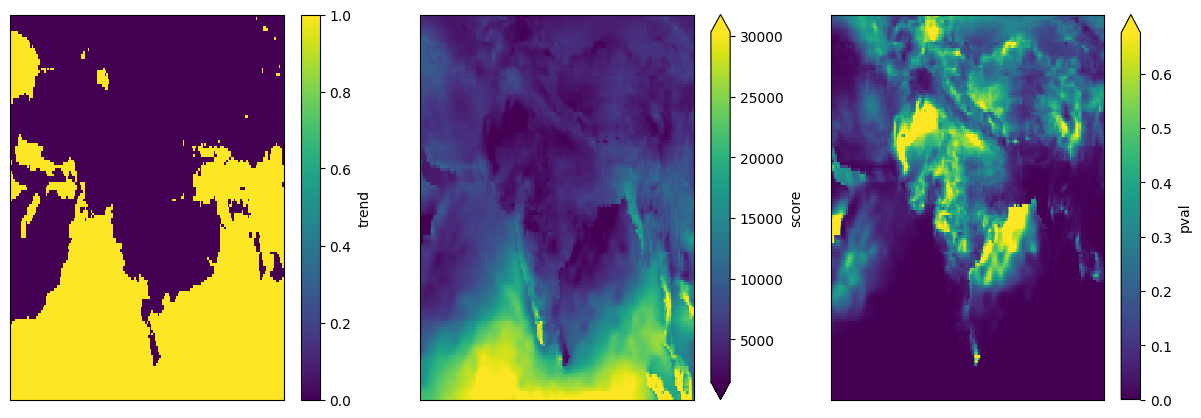

In [31]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
plt.tight_layout

change_trend.plot(x ='lon',y='lat',ax=axes[0])
change_score.plot(x ='lon',y='lat',ax=axes[1],robust =True)
change_pval.plot(x ='lon',y='lat',ax=axes[2],robust =True,vmax=0.5)


for i in axes :

  i.set_ylabel('')
  i.set_xlabel('')
  i.set_xticks([])
  i.set_yticks([])